# ACE_krill dataset testing image processing methods

## Data description

Data collected during the Antarctic Circumnavigation Expedition (ACE) in 2017 using an EK80 echosounder running at a frequency of 200 kHz.

## Objective

Extracting the krill parameters

## Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#import scipy.signal
#import skimage

## Import data



We import the csv file.

In [1]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

In [5]:
data_path = '/home/benjamin/Documents/datascience/ACE/'
data_filename = 'ACE_-D20170207-T104031.sv.csv'
filename = data_path + data_filename
info_df,data_trunc,depth_data = ACE_box.extract_data(filename)

------------------------------
Data matrix size: (2693, 9163)
Start depth (in meters): 0.09278976
Stop depth (in meters): 499.8584359
Nb of pixels along depth axis: 2693
Depth per pixel (in meters): 0.185579519547
Echogram truncated to the first 100 meters (492 pixels).
-----------------------------


In [6]:
depth_data = ACE_box.compute_depth_data(df)

Start depth (in meters): 0.09278976
Stop depth (in meters): 499.8584359
Nb of pixels along depth axis: 2693
Depth per pixel (in meters): 0.185579519547


In [8]:
data_rescale = ACE_box.fix_contrast(data_trunc)

<IPython.core.display.Javascript object>


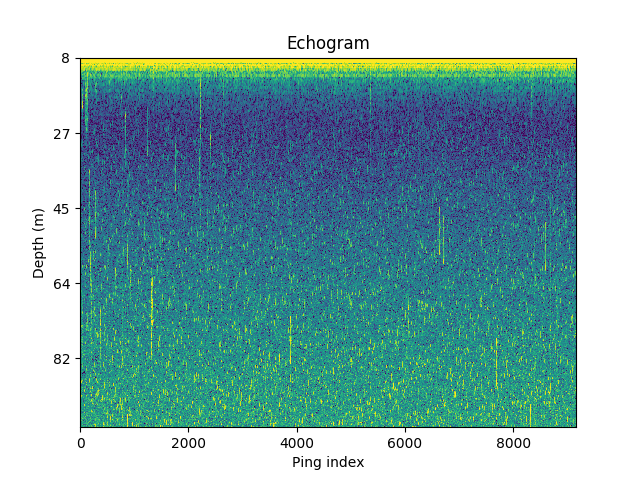

In [28]:
%matplotlib notebook
ACE_box.show_echogram(data_rescale,depth_data)

## Filtering processes

In [10]:
data2 =data_rescale.copy()
#data2[data<-70] = -70
#data2[data>-65] = -65
#data2 = data2 + 70

In [11]:
data3 = ACE_box.remove_vertical_lines(data2)

Number of noisy pixels removed:  1273408.0


In [12]:
data3 = ACE_box.substract_meanovertime(data3)

In [122]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

In [13]:
gauss_denoised = ACE_box.gaussian_filter(data3)

### Visualisation of the results of the first filtering processes

<IPython.core.display.Javascript object>


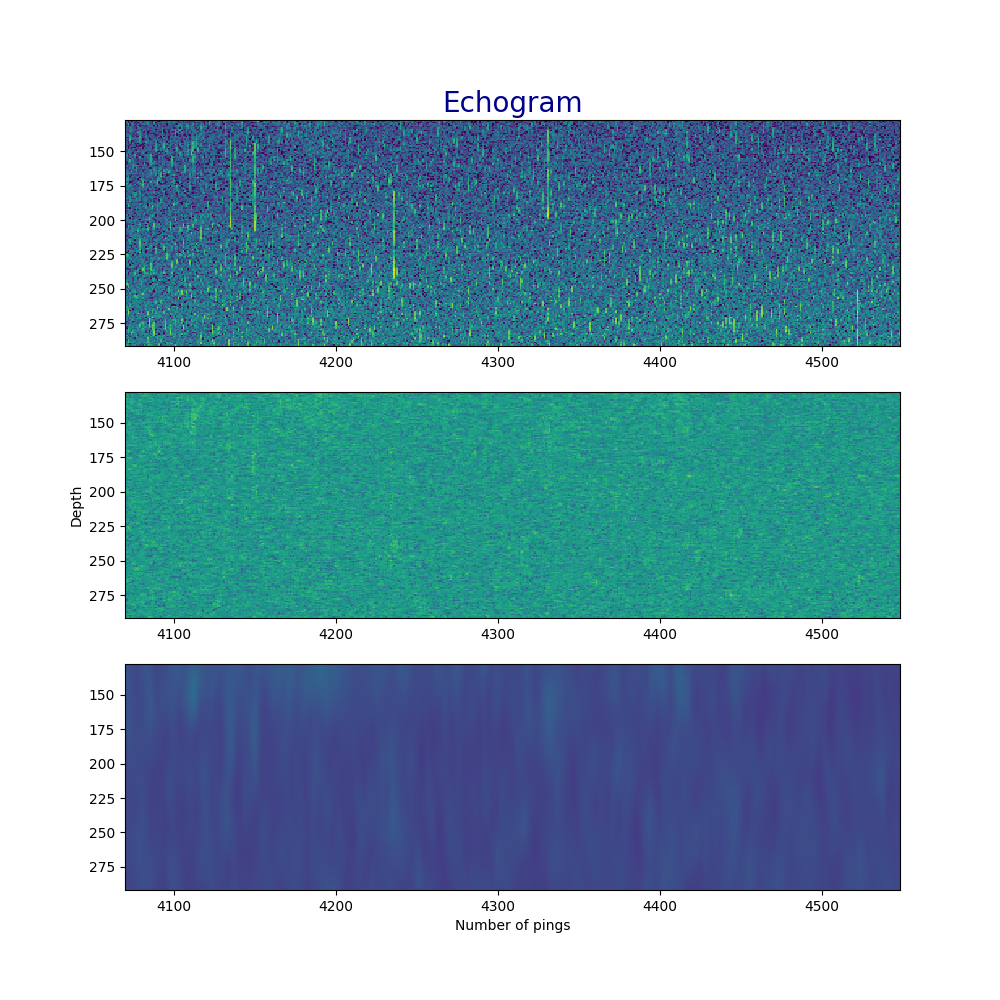

In [29]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10)) 
ax1 = plt.subplot(3,1,1)
ax1.imshow(data2[0:,:],aspect='auto')
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(3,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(data3[0:,:],aspect='auto')
plt.ylabel('Depth')
ax3 = plt.subplot(3,1,3, sharex=ax1, sharey=ax1)
ax3.imshow(gauss_denoised[0:,:],aspect='auto')
#ax3.imshow(databi[0:,:],aspect='auto')
plt.xlabel('Number of pings')
plt.show()

We then try to get rid of the remaining background noise by substracting the mean of each line line to every pixel (smoothing).

In [15]:
krillsignal,energy_fluctuation = ACE_box.krill_function(gauss_denoised,1)

<IPython.core.display.Javascript object>


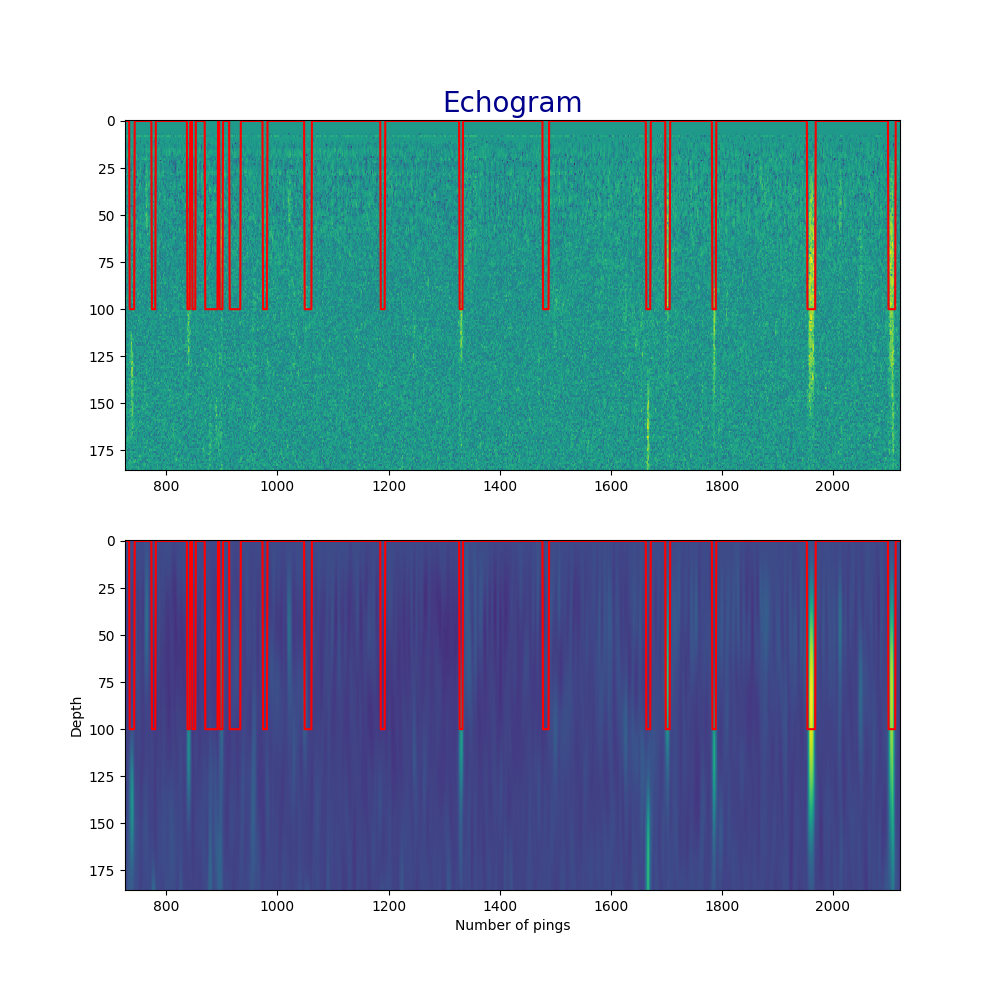

In [30]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(data3[0:,:],aspect='auto')
ax1.plot(krillsignal,color='r')
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(2,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(gauss_denoised,aspect='auto')
plt.ylabel('Depth')
ax2.plot(krillsignal,color='r')
plt.xlabel('Number of pings')
plt.show()

In [85]:
energy_fluctuation

0.54358662773407662

In [137]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

In [17]:
kchunks = ACE_box.extract_krillchunks(krillsignal,data3)
kchunks_gauss = ACE_box.extract_krillchunks(krillsignal,gauss_denoised)

In [18]:
print("Nb of chunks: ",len(kchunks))

Nb of chunks:  1914


In [140]:
idx = 1
print(kchunks[idx]['Ping_start_index'],kchunks[idx]['Ping_end_index'])
print(kchunks[idx]['data'].shape)

43 47
(492, 5)


<IPython.core.display.Javascript object>


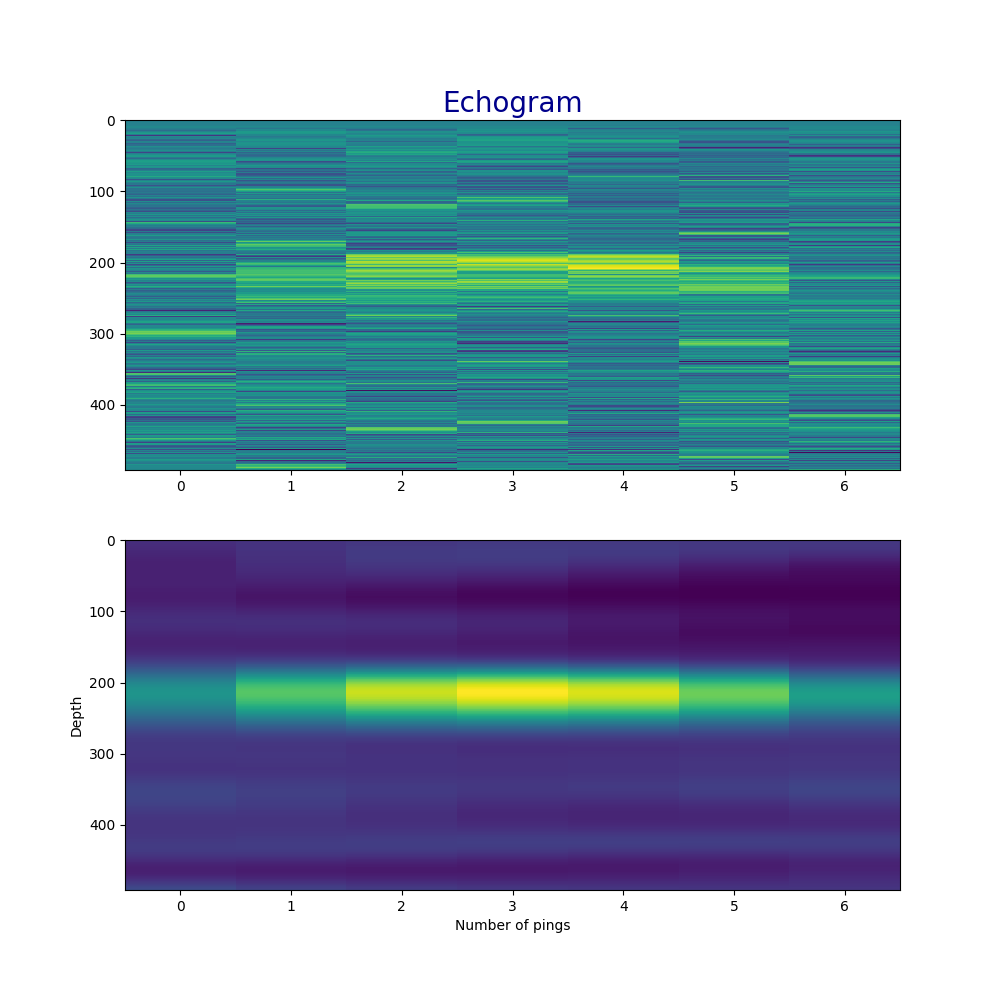

In [145]:
%matplotlib notebook
from matplotlib import pyplot as plt
idx=17
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(kchunks[idx]['data'],aspect='auto')
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(2,1,2)
ax2.imshow(kchunks_gauss[idx]['data'],aspect='auto')
plt.ylabel('Depth')
plt.xlabel('Number of pings')
plt.show()

In [22]:
krillsignal,energy_fluctuation = ACE_box.krill_function(gauss_denoised,1)
print('Energy fluctuation:',energy_fluctuation)
swarm_echo_list = ACE_box.extract_krillchunks(krillsignal,gauss_denoised)
print("Nb of swarms found: ",len(swarm_echo_list))
print('Extracting swarm information...')
echogram = data_trunc
swarm_list = ACE_box.info_from_swarm_list(swarm_echo_list,echogram,info_df,depth_data,filename)

Energy fluctuation: 0.685225957577
Nb of swarms found:  53
Extracting swarm information...
Number of noisy pixels removed:  1051391.0


<IPython.core.display.Javascript object>


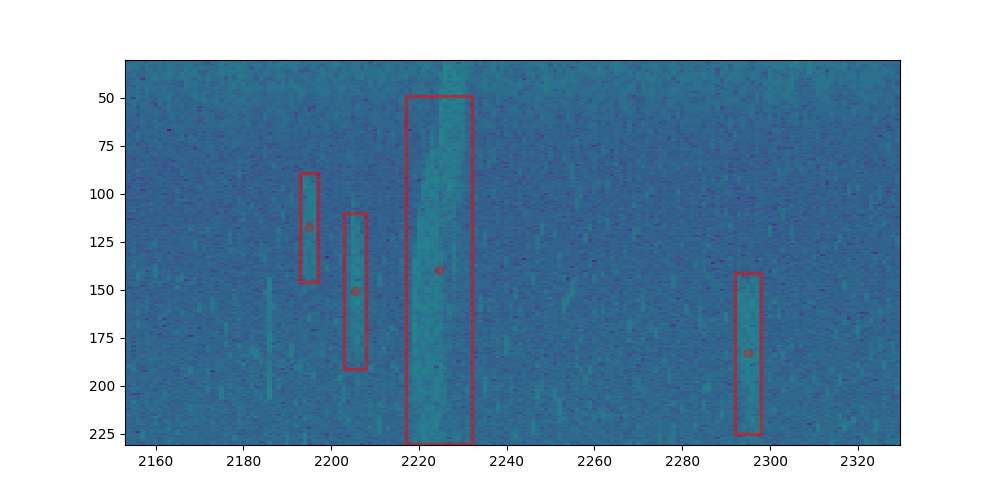

In [33]:
%matplotlib notebook
import matplotlib.patches as patches

D,L = [],[]
for swarm in swarm_list:
    D.append(swarm['depth_in_pixels'])
    L.append((swarm['ping_index_start']+swarm['ping_index_stop'])/2)

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111, aspect='equal')
#fig1,ax1 = plt.subplots()
ax1.imshow(data_trunc, aspect='auto')
ax1.scatter(L,D,c='r',alpha=0.3)
for swarm in swarm_list:
    height = swarm['height_in_pixels']
    y = swarm['depth_in_pixels'] - height/2
    x = swarm['ping_index_start']
    width = swarm['ping_index_stop'] - x
    rect = patches.Rectangle((x,y),width,height,fill=False,color='r',linewidth=2.5,alpha=0.5)
    # Create a Rectangle patch
    #rect = patches.Rectangle((50,100),40,30,linewidth=2.5,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)
plt.show()

In [25]:
filtered_swarm_list = ACE_box.remove_bad_swarms(swarm_list) 

Initial nb of swarms: 53, final nb of swarms: 52.


<IPython.core.display.Javascript object>


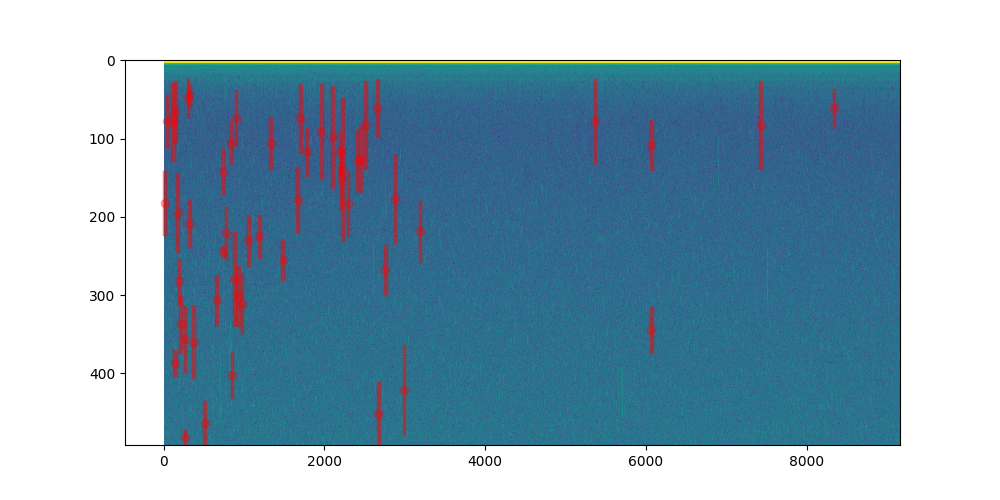

In [27]:
%matplotlib notebook
import matplotlib.patches as patches

D,L = [],[]
for swarm in filtered_swarm_list:
    D.append(swarm['depth_in_pixels'])
    L.append((swarm['ping_index_start']+swarm['ping_index_stop'])/2)

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111, aspect='equal')
#fig1,ax1 = plt.subplots()
ax1.imshow(data_trunc, aspect='auto')
ax1.scatter(L,D,c='r',alpha=0.3)
for swarm in filtered_swarm_list:
    height = swarm['height_in_pixels']
    y = swarm['depth_in_pixels'] - height/2
    x = swarm['ping_index_start']
    width = swarm['ping_index_stop'] - x
    rect = patches.Rectangle((x,y),width,height,fill=False,color='r',linewidth=2.5,alpha=0.5)
    # Create a Rectangle patch
    #rect = patches.Rectangle((50,100),40,30,linewidth=2.5,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax1.add_patch(rect)
plt.show()